In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import CrossEntropyLoss, Linear
from torch.optim import Adam
from torchvision import transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.model_selection import train_test_split

In [2]:
!unzip Q2_Data.zip

Archive:  Q2_Data.zip
   creating: LYMPHOCYTE/
  inflating: LYMPHOCYTE/BloodImage_00020.jpg  
  inflating: LYMPHOCYTE/BloodImage_00021.jpg  
  inflating: LYMPHOCYTE/BloodImage_00037.jpg  
  inflating: LYMPHOCYTE/BloodImage_00038.jpg  
  inflating: LYMPHOCYTE/BloodImage_00047.jpg  
  inflating: LYMPHOCYTE/BloodImage_00054.jpg  
  inflating: LYMPHOCYTE/BloodImage_00055.jpg  
  inflating: LYMPHOCYTE/BloodImage_00076.jpg  
  inflating: LYMPHOCYTE/BloodImage_00089.jpg  
  inflating: LYMPHOCYTE/BloodImage_00099.jpg  
  inflating: LYMPHOCYTE/BloodImage_00111.jpg  
  inflating: LYMPHOCYTE/BloodImage_00120.jpg  
  inflating: LYMPHOCYTE/BloodImage_00134.jpg  
  inflating: LYMPHOCYTE/BloodImage_00140.jpg  
  inflating: LYMPHOCYTE/BloodImage_00148.jpg  
  inflating: LYMPHOCYTE/BloodImage_00157.jpg  
  inflating: LYMPHOCYTE/BloodImage_00191.jpg  
  inflating: LYMPHOCYTE/BloodImage_00206.jpg  
  inflating: LYMPHOCYTE/BloodImage_00211.jpg  
  inflating: LYMPHOCYTE/BloodImage_00217.jpg  
  inflating: 

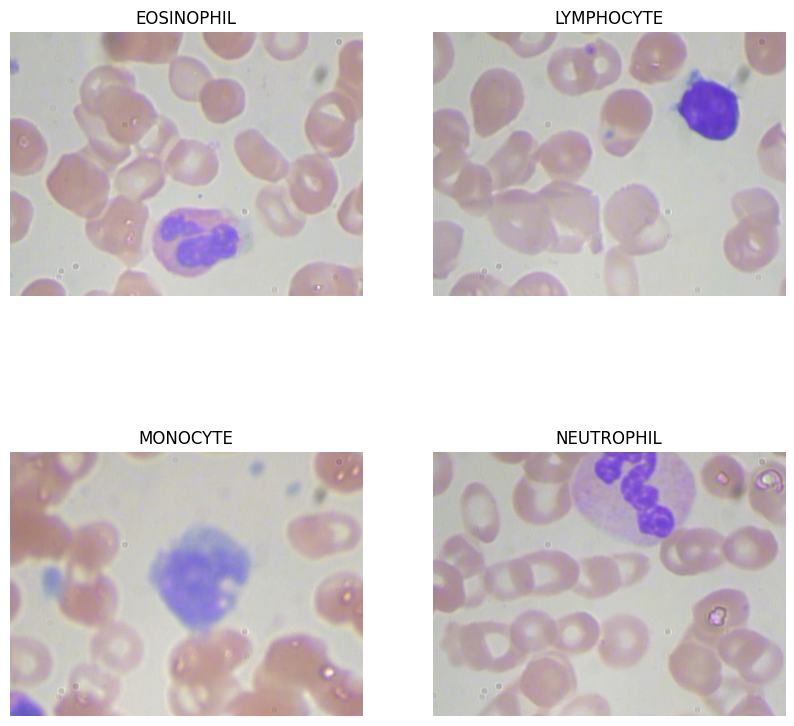

In [3]:
class_folders = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
class_counts = {}

plt.figure(figsize=(10, 10))
for i, class_folder in enumerate(class_folders):
    class_images = os.listdir(class_folder)
    class_counts[class_folder] = len(class_images)
    random_image_name = np.random.choice(class_images)
    random_image_path = os.path.join(class_folder, random_image_name)
    img = Image.open(random_image_path)

    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(class_folder)
    plt.axis('off')

plt.show()

In [4]:
for class_folder, count in class_counts.items():
    print(f"{class_folder}: {count} images")

EOSINOPHIL: 88 images
LYMPHOCYTE: 33 images
MONOCYTE: 20 images
NEUTROPHIL: 206 images


In [5]:
max_count = max(class_counts.values())

augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resized_normal_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

all_images = []
all_labels = []

for idx, cls in enumerate(class_folders):
    class_path = os.path.join(cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    if len(images) < max_count:
        num_to_generate = max_count - len(images)
        print(f"Generating {num_to_generate} images for class {cls} ...")

        for image in images:
            img_path = os.path.join(class_path, image)
            img = Image.open(img_path).convert("RGB")
            augmented_img = resized_normal_transforms(img)
            all_images.append(augmented_img)
            all_labels.append(idx)

        for i in range(num_to_generate):
            img_name = images[i % len(images)]
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert("RGB")
            augmented_img = augment_transforms(img)
            all_images.append(augmented_img)
            all_labels.append(idx)
    else:
        print(f"No Generating images for class {cls}. It has {max_count} Images.")
        for image in images:
            img_path = os.path.join(class_path, image)
            img = Image.open(img_path).convert("RGB")
            augmented_img = resized_normal_transforms(img)
            all_images.append(augmented_img)
            all_labels.append(idx)

Generating 118 images for class EOSINOPHIL ...
Generating 173 images for class LYMPHOCYTE ...
Generating 186 images for class MONOCYTE ...
No Generating images for class NEUTROPHIL. It has 206 Images.


In [6]:
print(f"Total images: {len(all_images)}")

train_data, val_data, train_labels, val_labels = train_test_split(all_images, all_labels, test_size=0.1, random_state=42)

print(f"Train images: {len(train_data)}")
print(f"Validation images: {len(val_data)}")

Total images: 824
Train images: 741
Validation images: 83


In [8]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=4,  # number of classes
)
print(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [10]:
# Fitting data to models
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_folders = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        if self.transform and not isinstance(image, torch.Tensor):
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(train_data, train_labels, transform=transform)
val_dataset = CustomDataset(val_data, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
num_epochs = 10

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85801732
Trainable parameters: 3076
Epoch 1/10 - Train Loss: 1.3860 - Train Accuracy: 32.52% - Val Loss: 1.3681 - Val Accuracy: 48.19%
Epoch 2/10 - Train Loss: 1.3601 - Train Accuracy: 41.84% - Val Loss: 1.3460 - Val Accuracy: 54.22%
Epoch 3/10 - Train Loss: 1.3380 - Train Accuracy: 56.55% - Val Loss: 1.3237 - Val Accuracy: 65.06%
Epoch 4/10 - Train Loss: 1.3166 - Train Accuracy: 61.00% - Val Loss: 1.3027 - Val Accuracy: 61.45%
Epoch 5/10 - Train Loss: 1.2939 - Train Accuracy: 60.86% - Val Loss: 1.2842 - Val Accuracy: 63.86%
Epoch 6/10 - Train Loss: 1.2773 - Train Accuracy: 62.08% - Val Loss: 1.2630 - Val Accuracy: 66.27%
Epoch 7/10 - Train Loss: 1.2546 - Train Accuracy: 64.37% - Val Loss: 1.2439 - Val Accuracy: 65.06%
Epoch 8/10 - Train Loss: 1.2440 - Train Accuracy: 65.05% - Val Loss: 1.2256 - Val Accuracy: 63.86%
Epoch 9/10 - Train Loss: 1.2226 - Train Accuracy: 66.67% - Val Loss: 1.2072 - Val Accuracy: 63.86%
Epoch 10/10 - Train Loss: 1.2046 - Train Accuracy: 66.5

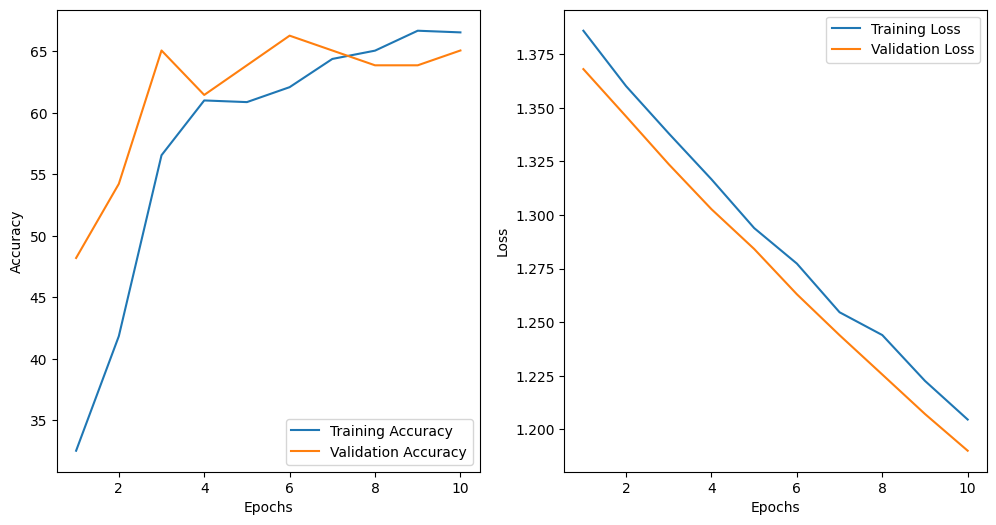

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
loss_function = CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

train_losses_1 = []
val_losses_1 = []
train_accuracies_1 = []
val_accuracies_1 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_losses_1.append(epoch_train_loss)
    train_accuracies_1.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct / total
    val_losses_1.append(epoch_val_loss)
    val_accuracies_1.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_1, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_1, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_1, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85801732
Trainable parameters: 14921476
Epoch 1/10 - Train Loss: 1.2985 - Train Accuracy: 44.13% - Val Loss: 1.2148 - Val Accuracy: 57.83%
Epoch 2/10 - Train Loss: 1.1503 - Train Accuracy: 56.28% - Val Loss: 1.0971 - Val Accuracy: 57.83%
Epoch 3/10 - Train Loss: 1.0324 - Train Accuracy: 62.21% - Val Loss: 1.0049 - Val Accuracy: 74.70%
Epoch 4/10 - Train Loss: 0.9072 - Train Accuracy: 73.41% - Val Loss: 0.8593 - Val Accuracy: 73.49%
Epoch 5/10 - Train Loss: 0.7664 - Train Accuracy: 79.76% - Val Loss: 0.7603 - Val Accuracy: 77.11%
Epoch 6/10 - Train Loss: 0.6429 - Train Accuracy: 88.53% - Val Loss: 0.7517 - Val Accuracy: 79.52%
Epoch 7/10 - Train Loss: 0.5745 - Train Accuracy: 90.42% - Val Loss: 0.5633 - Val Accuracy: 83.13%
Epoch 8/10 - Train Loss: 0.4294 - Train Accuracy: 95.28% - Val Loss: 0.5064 - Val Accuracy: 86.75%
Epoch 9/10 - Train Loss: 0.3536 - Train Accuracy: 96.36% - Val Loss: 0.4713 - Val Accuracy: 87.95%
Epoch 10/10 - Train Loss: 0.2761 - Train Accuracy: 

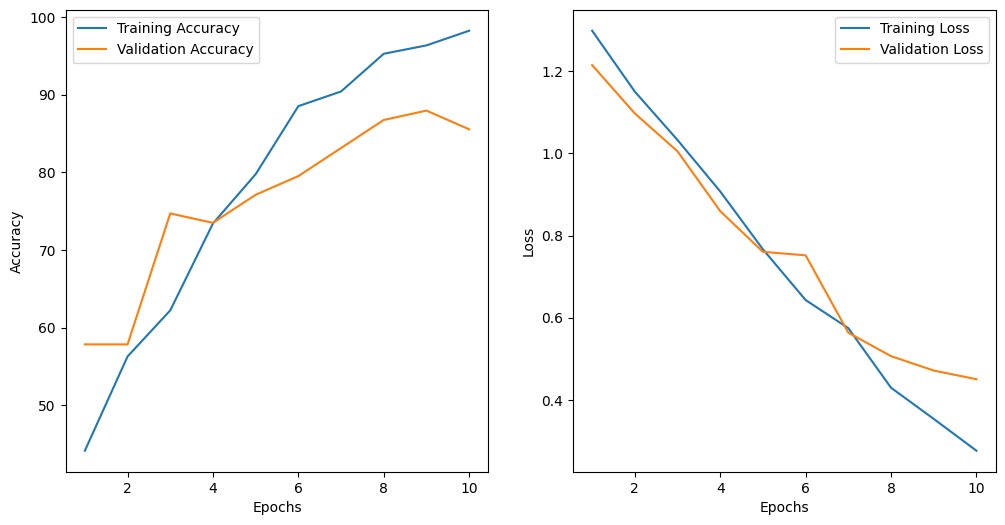

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001)
loss_function = CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False

for param in model.vit.embeddings.parameters():
    param.requires_grad = True

for param in model.vit.encoder.layer[0].parameters():
    param.requires_grad = True

for param in model.vit.encoder.layer[1].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

train_losses_2 = []
val_losses_2 = []
train_accuracies_2 = []
val_accuracies_2 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_losses_2.append(epoch_train_loss)
    train_accuracies_2.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct / total
    val_losses_2.append(epoch_val_loss)
    val_accuracies_2.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_2, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_2, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85801732
Trainable parameters: 14178820
Epoch 1/10 - Train Loss: 1.1824 - Train Accuracy: 57.62% - Val Loss: 0.9206 - Val Accuracy: 71.08%
Epoch 2/10 - Train Loss: 0.7389 - Train Accuracy: 77.19% - Val Loss: 0.6238 - Val Accuracy: 75.90%
Epoch 3/10 - Train Loss: 0.4732 - Train Accuracy: 85.83% - Val Loss: 0.4551 - Val Accuracy: 83.13%
Epoch 4/10 - Train Loss: 0.3171 - Train Accuracy: 92.44% - Val Loss: 0.3333 - Val Accuracy: 90.36%
Epoch 5/10 - Train Loss: 0.2123 - Train Accuracy: 95.28% - Val Loss: 0.3218 - Val Accuracy: 85.54%
Epoch 6/10 - Train Loss: 0.1467 - Train Accuracy: 97.57% - Val Loss: 0.3285 - Val Accuracy: 87.95%
Epoch 7/10 - Train Loss: 0.1093 - Train Accuracy: 97.71% - Val Loss: 0.3583 - Val Accuracy: 84.34%
Epoch 8/10 - Train Loss: 0.0752 - Train Accuracy: 98.92% - Val Loss: 0.2894 - Val Accuracy: 87.95%
Epoch 9/10 - Train Loss: 0.0579 - Train Accuracy: 99.73% - Val Loss: 0.3395 - Val Accuracy: 89.16%
Epoch 10/10 - Train Loss: 0.0818 - Train Accuracy: 

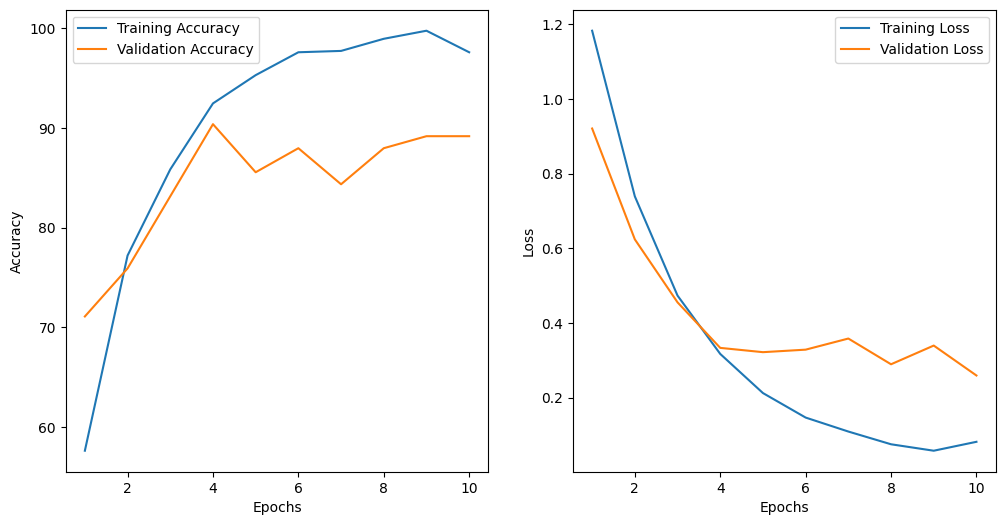

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.00001)
loss_function = CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False

for param in model.vit.encoder.layer[-1].parameters():
    param.requires_grad = True

for param in model.vit.encoder.layer[-2].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

train_losses_3 = []
val_losses_3 = []
train_accuracies_3 = []
val_accuracies_3 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_losses_3.append(epoch_train_loss)
    train_accuracies_3.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct / total
    val_losses_3.append(epoch_val_loss)
    val_accuracies_3.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_3, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_3, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_3, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85801732
Trainable parameters: 85801732
Epoch 1/10 - Train Loss: 1.2924 - Train Accuracy: 52.50% - Val Loss: 1.1598 - Val Accuracy: 74.70%
Epoch 2/10 - Train Loss: 1.0401 - Train Accuracy: 79.76% - Val Loss: 0.9349 - Val Accuracy: 83.13%
Epoch 3/10 - Train Loss: 0.8240 - Train Accuracy: 86.10% - Val Loss: 0.7496 - Val Accuracy: 87.95%
Epoch 4/10 - Train Loss: 0.6375 - Train Accuracy: 92.58% - Val Loss: 0.6143 - Val Accuracy: 89.16%
Epoch 5/10 - Train Loss: 0.4968 - Train Accuracy: 95.14% - Val Loss: 0.5147 - Val Accuracy: 90.36%
Epoch 6/10 - Train Loss: 0.3952 - Train Accuracy: 96.22% - Val Loss: 0.4479 - Val Accuracy: 91.57%
Epoch 7/10 - Train Loss: 0.3111 - Train Accuracy: 98.52% - Val Loss: 0.3906 - Val Accuracy: 92.77%
Epoch 8/10 - Train Loss: 0.2496 - Train Accuracy: 99.46% - Val Loss: 0.3585 - Val Accuracy: 92.77%
Epoch 9/10 - Train Loss: 0.2052 - Train Accuracy: 99.87% - Val Loss: 0.3282 - Val Accuracy: 92.77%
Epoch 10/10 - Train Loss: 0.1730 - Train Accuracy: 

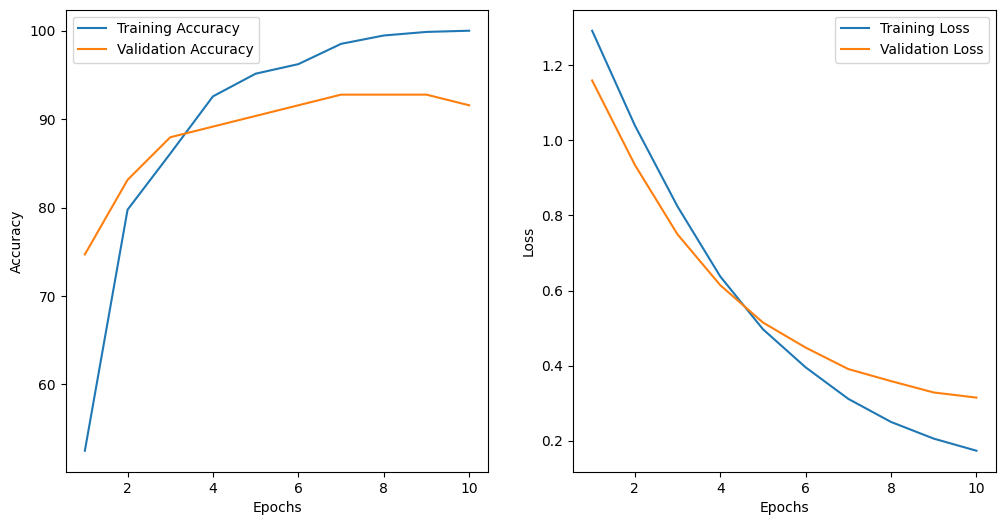

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.00001)
loss_function = CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


train_losses_4 = []
val_losses_4 = []
train_accuracies_4 = []
val_accuracies_4 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_losses_4.append(epoch_train_loss)
    train_accuracies_4.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct / total
    val_losses_4.append(epoch_val_loss)
    val_accuracies_4.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_4, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_4, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_4, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_4, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Total parameters: 6957956
Trainable parameters: 6957956
Epoch 1/10 - Train Loss: 1.0102 - Train Accuracy: 56.95% - Val Loss: 0.7682 - Val Accuracy: 69.88%
Epoch 2/10 - Train Loss: 0.4117 - Train Accuracy: 92.98% - Val Loss: 0.4442 - Val Accuracy: 85.54%
Epoch 3/10 - Train Loss: 0.1667 - Train Accuracy: 99.33% - Val Loss: 0.3275 - Val Accuracy: 89.16%
Epoch 4/10 - Train Loss: 0.0820 - Train Accuracy: 99.73% - Val Loss: 0.2866 - Val Accuracy: 90.36%
Epoch 5/10 - Train Loss: 0.0462 - Train Accuracy: 100.00% - Val Loss: 0.2843 - Val Accuracy: 87.95%
Epoch 6/10 - Train Loss: 0.0574 - Train Accuracy: 100.00% - Val Loss: 0.2408 - Val Accuracy: 90.36%
Epoch 7/10 - Train Loss: 0.0303 - Train Accuracy: 100.00% - Val Loss: 0.2295 - Val Accuracy: 92.77%
Epoch 8/10 - Train Loss: 0.0203 - Train Accuracy: 100.00% - Val Loss: 0.2528 - Val Accuracy: 92.77%
Epoch 9/10 - Train Loss: 0.0142 - Train Accuracy: 100.00% - Val Loss: 0.2088 - Val Accuracy: 92.77%
Epoch 10/10 - Train Loss: 0.0244 - Train Accurac

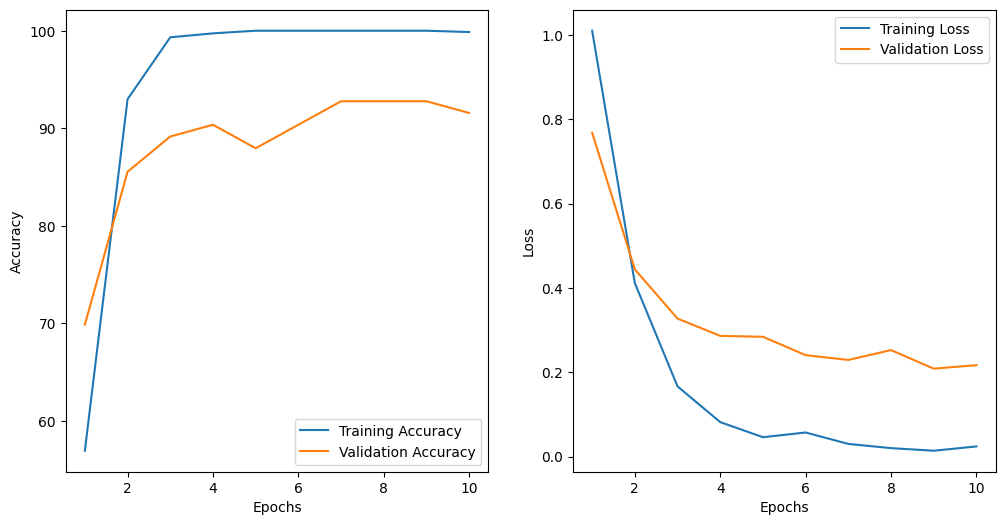

In [ ]:
model = models.densenet121(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.00001)
loss_function = CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = True

model.classifier = Linear(model.classifier.in_features, 4).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

train_losses_5 = []
val_losses_5 = []
train_accuracies_5 = []
val_accuracies_5 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_losses_5.append(epoch_train_loss)
    train_accuracies_5.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct / total
    val_losses_5.append(epoch_val_loss)
    val_accuracies_5.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_5, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_5, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_5, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Total parameters: 6957956
Trainable parameters: 4100
Epoch 1/10 - Train Loss: 1.3685 - Train Accuracy: 33.33% - Val Loss: 1.2733 - Val Accuracy: 38.55%
Epoch 2/10 - Train Loss: 1.1387 - Train Accuracy: 63.97% - Val Loss: 1.1914 - Val Accuracy: 44.58%
Epoch 3/10 - Train Loss: 1.0002 - Train Accuracy: 74.49% - Val Loss: 1.1220 - Val Accuracy: 49.40%
Epoch 4/10 - Train Loss: 0.8837 - Train Accuracy: 81.92% - Val Loss: 1.0660 - Val Accuracy: 56.63%
Epoch 5/10 - Train Loss: 0.7938 - Train Accuracy: 83.00% - Val Loss: 1.0153 - Val Accuracy: 60.24%
Epoch 6/10 - Train Loss: 0.7186 - Train Accuracy: 86.37% - Val Loss: 0.9744 - Val Accuracy: 61.45%
Epoch 7/10 - Train Loss: 0.6498 - Train Accuracy: 89.07% - Val Loss: 0.9283 - Val Accuracy: 61.45%
Epoch 8/10 - Train Loss: 0.5719 - Train Accuracy: 92.71% - Val Loss: 0.8695 - Val Accuracy: 67.47%
Epoch 9/10 - Train Loss: 0.5177 - Train Accuracy: 92.98% - Val Loss: 0.8319 - Val Accuracy: 67.47%
Epoch 10/10 - Train Loss: 0.4662 - Train Accuracy: 95.82

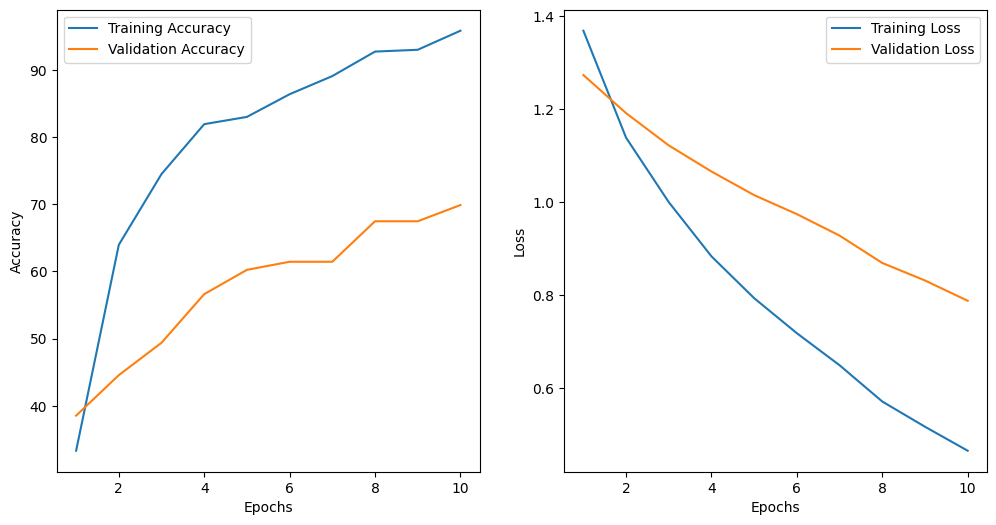

In [14]:
model = models.densenet121(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = Adam(model.parameters(), lr=0.00001)
loss_function = CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier = Linear(model.classifier.in_features, 4).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

train_losses_6 = []
val_losses_6 = []
train_accuracies_6 = []
val_accuracies_6 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct / total
    train_losses_6.append(epoch_train_loss)
    train_accuracies_6.append(epoch_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct / total
    val_losses_6.append(epoch_val_loss)
    val_accuracies_6.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_6, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_6, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_6, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_6, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


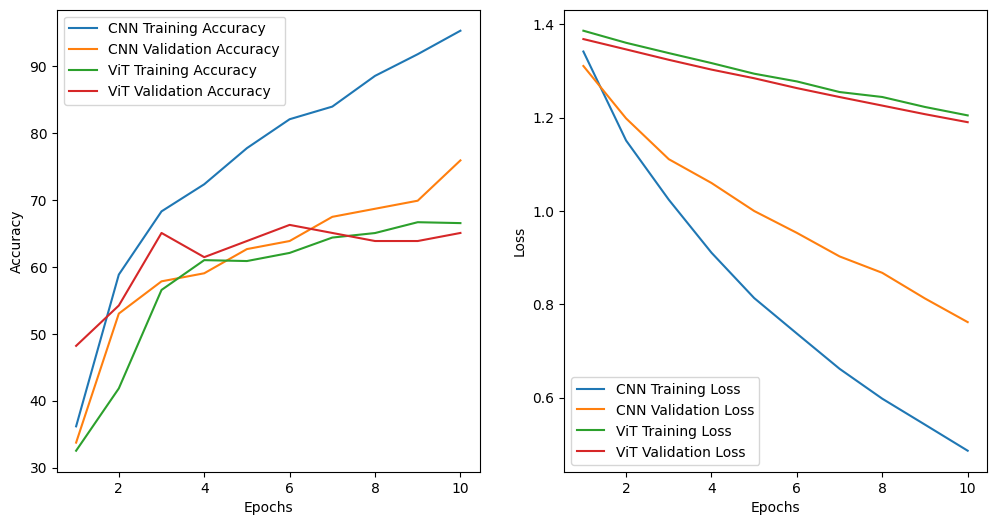

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies_6, label='CNN Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_6, label='CNN Validation Accuracy')
plt.plot(range(1, num_epochs+1), train_accuracies_1, label='ViT Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_1, label='ViT Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_6, label='CNN Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_6, label='CNN Validation Loss')
plt.plot(range(1, num_epochs+1), train_losses_1, label='ViT Training Loss')
plt.plot(range(1, num_epochs+1), val_losses_1, label='ViT Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()